In [102]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [134]:
from lxml import etree
parser=etree.XMLParser(load_dtd= True)
tree = etree.parse("./features.xml",parser)
root = tree.getroot()
names=[]
target_names=''
featrue_names=[]
oh={}
for f in root:
    f_type = f.tag
    f_name = f.get('name')
    names.append(f_name)
    ohrange = f.getchildren()[0]
    targetFlag = f.getchildren()[2]
    trainFlag = f.getchildren()[3]
    onFlag = f.getchildren()[4]
    
    if targetFlag.text == 'true':
        target_names = f_name
    if trainFlag.text == 'true':
        featrue_names.append(f_name)
        oh[f_name] = list(range(0,int(ohrange.text)))
    
names.append('cal_dt')

In [138]:
data = pd.read_csv('/Users/huzuoliang/Desktop/train_set/ajk/1212headweek',sep='\t',names=names)
data = data[data['city_id'] == 14].reset_index(drop=True)
data.drop(['cal_dt'],axis=1, inplace=True)
data.shape

(393715, 107)

In [ ]:
oh_cols = pd.DataFrame()
for k,v in oh.items():
    cols_name_oh = pd.get_dummies(v).rename(lambda x: k +'_'+ str(v[x])).T
    cols_name_oh[k +'_-1']=-1
    k_oh = cols_name_oh.loc[train[k]]
    k_oh.reset_index(inplace=True)
    # reset_index后会自动加一个index,以保存原始的列index
    # 避免settingwithcopyWarning
    k_oh = k_oh.drop('index', axis=1)
    oh_cols = pd.concat([oh_cols,k_oh], axis=1)

all_data = pd.concat([oh_cols,label],axis=1)

In [70]:
data_label=data[target_names]
data.drop([target_names],axis=1, inplace=True)
data_hash = data.applymap(lambda x:abs(hash(name+'_' + str(x))) % 1000)

In [71]:
data_final=np.zeros((data_hash.shape[0], 1000))
for index, row in data_hash.iterrows():
    data_final[index, row]=1

In [76]:
all_data = pd.concat([data_label,pd.DataFrame(data_final)],axis=1)
all_data.shape

(393715, 1001)

In [79]:
from sklearn.utils import shuffle  
all_data = shuffle(all_data) 
sz = all_data.shape
train = all_data.head(int(sz[0] * 0.8)) 
test = all_data.tail(int(sz[0] * 0.2))
predictors = [x for x in train.columns if x not in [target_names]]
train.shape,test.shape

((314972, 1001), (78743, 1001))

In [89]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.25,max_iter=1000)
lr.fit(train[predictors], train[target_names])

predprob = lr.predict_proba(train[predictors])[:, 1]
print('AUC Score (Train): %f' % metrics.roc_auc_score(train[target_names], predprob))
print('Logloss Score (Train): %f' % metrics.log_loss(train[target_names], predprob))
predprob = lr.predict_proba(test[predictors])[:, 1]
print('AUC Score (TEST): %f' % metrics.roc_auc_score(test[target_names], predprob))
print('Logloss Score (TEST): %f' % metrics.log_loss(test[target_names], predprob))

AUC Score (Train): 0.675804
Logloss Score (Train): 0.437451
AUC Score (TEST): 0.667196
Logloss Score (TEST): 0.440221


In [90]:
PARAMS = {'learning_rate': 0.06,
          'n_estimators': 300,
          'max_depth': 9,
          'min_child_weight': 10,
          'gamma': 0.1,
          'reg_alpha': 0,
          'subsample': 0.85,
          'colsample_bytree': 0.85,
          'objective': 'binary:logistic',
          'nthread': 4,
          'seed': 27,
          'scale_pos_weight': 1}


Model Report
Accuracy : 0.8246
AUC Score (Train): 0.719684
Logloss Score (Train): 0.422446

/Users/huzuoliang/app/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Accuracy : 0.8242
AUC Score (Test): 0.685752
Logloss Score (Test): 0.433264


Text(0,0.5,'Feature Importance Score')

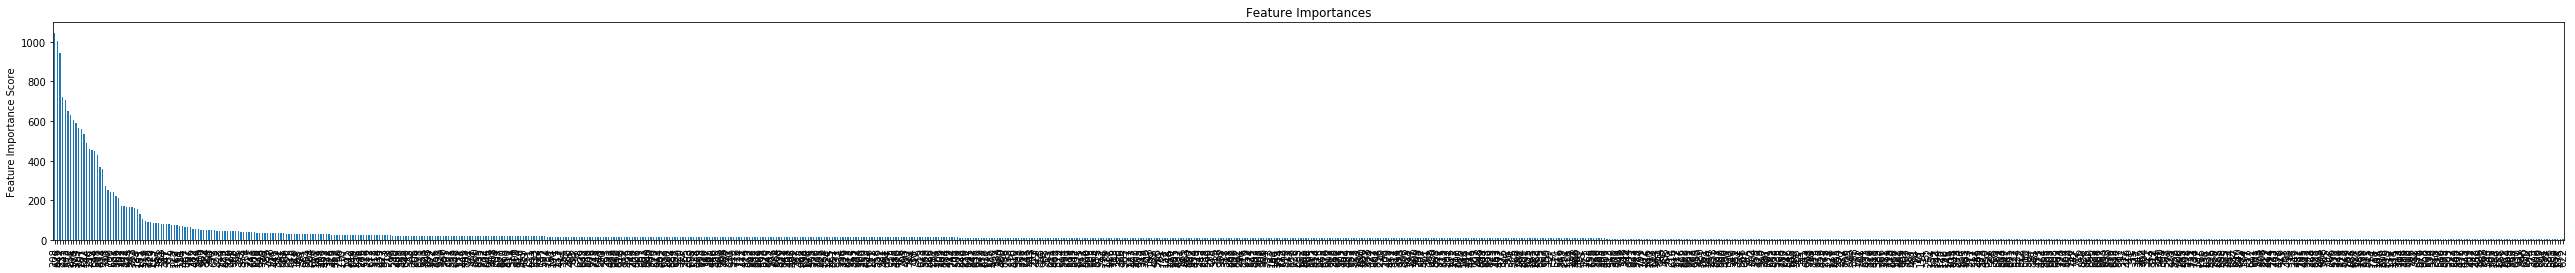

In [91]:
dtrain = train
dtest = test
alg = XGBClassifier(**PARAMS)
# Fit the algorithm on the data
alg.fit(dtrain[predictors], dtrain[target_names], eval_metric='auc')

# Predict training set:
dtrain_predictions = alg.predict(dtrain[predictors])
dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]

# Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target_names].values, dtrain_predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target_names], dtrain_predprob))
print("Logloss Score (Train): %f" % metrics.log_loss(dtrain[target_names], dtrain_predprob))
#     Predict on testing data:
dtest_predictions = alg.predict(dtest[predictors])
dtest['predprob'] = alg.predict_proba(dtest[predictors])[:, 1]
print("Accuracy : %.4g" % metrics.accuracy_score(dtest[target_names].values, dtest_predictions))
print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest[target_names], dtest['predprob']))
print('Logloss Score (Test): %f' % metrics.log_loss(dtest[target_names], dtest['predprob']))
#     plt.figure()
#     xgb.plot_importance(alg.get_booster())
#     plt.show()
# print(alg.booster().get_score('weight'))
plt.figure(figsize=(45,4))
feat_imp = pd.Series(alg.get_booster().get_score()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [92]:
dtest['predprob'].mean(),sum(dtest[target_names])/len(dtest)

(0.17644965648651123, 0.17646012978931461)

In [101]:
print(alg.missing.real == np.nan)

SyntaxError: keyword can't be an expression (<ipython-input-101-b7b7a4762863>, line 1)